In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)

import numpy as np

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.ticker as ticker

import seaborn as sns
sns.set_style('whitegrid')

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

from sklearn import metrics

from sklearn.linear_model import LinearRegression

import warnings

import datetime
from datetime import timedelta 

In [2]:
df_raw = pd.read_excel(r'/Users/aditya.manthri/mlpark/large_data_set_Parking Occupancy.xlsx')
df_raw.dtypes

TimeStamp         datetime64[ns]
Facility                  object
Occupied                   int64
Address                   object
Vacant                     int64
TotalAvailable             int64
dtype: object

In [3]:
df_raw.head(10)

,TimeStamp,Facility,Occupied,Address,Vacant,TotalAvailable
0,2018-05-30 04:42:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166
1,2018-12-20 04:12:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166
2,2018-12-20 04:42:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166
3,2018-12-06 04:12:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166
4,2019-12-19 04:42:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166
5,2018-12-13 04:42:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166
6,2018-12-13 04:12:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166
7,2018-12-06 04:42:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166
8,2019-12-19 04:12:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166
9,2019-12-26 04:42:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166


In [4]:
len(df_raw)

827375

In [5]:
df_clean = df_raw.copy()
df_clean.TimeStamp = df_clean.TimeStamp.astype('datetime64')
df_clean['PercentOccupied'] = df_clean.Occupied / df_clean.TotalAvailable
df_clean['date'] = df_clean.TimeStamp.dt.date
df_clean['dayofweek'] = df_clean.TimeStamp.dt.dayofweek
df_clean['date_time_halfhour'] = df_clean.TimeStamp.dt.round('30min')
df_clean['time'] = df_clean.date_time_halfhour.dt.time

In [6]:
df_clean.head()

,TimeStamp,Facility,Occupied,Address,Vacant,TotalAvailable,PercentOccupied,date,dayofweek,date_time_halfhour,time
0,2018-05-30 04:42:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166,0.0,2018-05-30,2,2018-05-30 04:30:00,04:30:00
1,2018-12-20 04:12:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166,0.0,2018-12-20,3,2018-12-20 04:00:00,04:00:00
2,2018-12-20 04:42:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166,0.0,2018-12-20,3,2018-12-20 04:30:00,04:30:00
3,2018-12-06 04:12:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166,0.0,2018-12-06,3,2018-12-06 04:00:00,04:00:00
4,2019-12-19 04:42:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166,0.0,2019-12-19,3,2019-12-19 04:30:00,04:30:00


In [7]:
df_clean.groupby('time').size()

time
00:00:00    17682
00:30:00    16891
01:00:00    17677
01:30:00    16872
02:00:00    17584
02:30:00    16828
03:00:00    17171
03:30:00    16826
04:00:00    17569
04:30:00    16834
05:00:00    17504
05:30:00    16915
06:00:00    17592
06:30:00    16818
07:00:00    17517
07:30:00    16924
08:00:00    17631
08:30:00    16839
09:00:00    17620
09:30:00    16839
10:00:00    17649
10:30:00    16812
11:00:00    17667
11:30:00    16850
12:00:00    17632
12:30:00    16851
13:00:00    17653
13:30:00    16860
14:00:00    17664
14:30:00    16855
15:00:00    17647
15:30:00    16835
16:00:00    17648
16:30:00    16882
17:00:00    17643
17:30:00    16892
18:00:00    17648
18:30:00    16893
19:00:00    17619
19:30:00    16911
20:00:00    17631
20:30:00    16897
21:00:00    17639
21:30:00    16902
22:00:00    17650
22:30:00    16887
23:00:00    17656
23:30:00    16869
dtype: int64

In [8]:
pre_len = len(df_clean)
df_clean = df_clean.drop_duplicates()

post_len = len(df_clean)

dropped_len = pre_len - post_len
print(dropped_len)

0


In [9]:
# Note that some values are out of range of 0-100%
print('Minimum Percent Occupied: {:.2%}'.format(df_clean.PercentOccupied.min()))
print('Maximum Percent Occupied: {:.2%}'.format(df_clean.PercentOccupied.max()))

Minimum Percent Occupied: 0.00%
Maximum Percent Occupied: 42509.04%


In [10]:
df_clean.Occupied = df_clean.apply(lambda x: max(0, min(x['TotalAvailable'], x['Occupied'])), axis=1)
df_clean['PercentOccupied'] = df_clean.Occupied / df_clean.TotalAvailable

In [11]:
# Re-check range
print('Minimum Percent Occupied: {:.2%}'.format(df_clean.PercentOccupied.min()))
print('Maximum Percent Occupied: {:.2%}'.format(df_clean.PercentOccupied.max()))

Minimum Percent Occupied: 0.00%
Maximum Percent Occupied: 100.00%


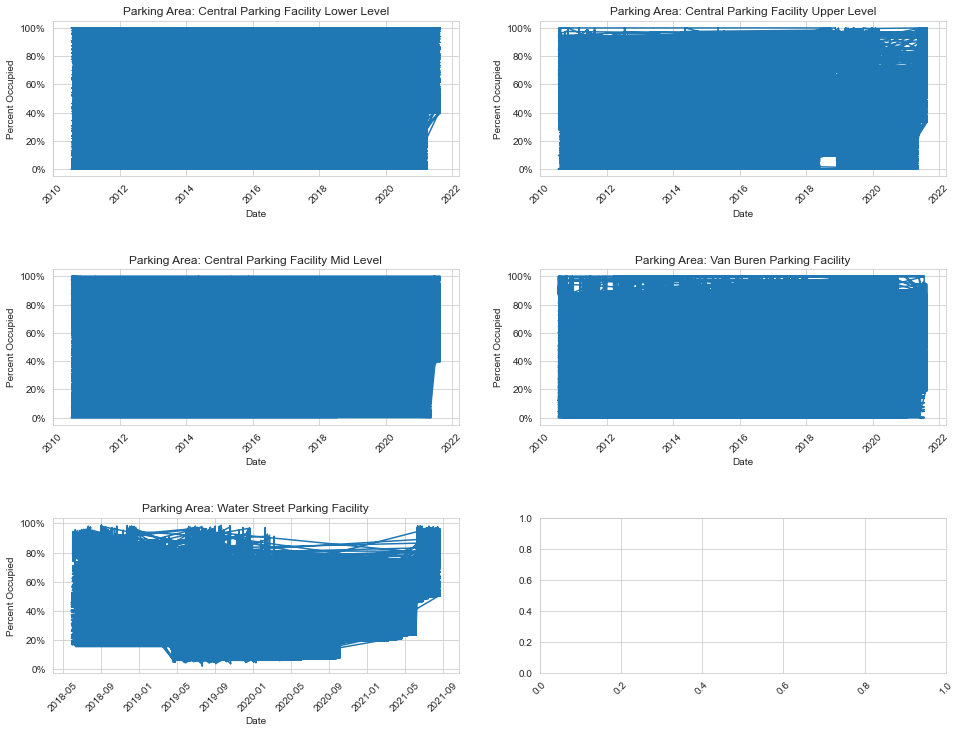

In [12]:
def sample_plots_by_scn(df, num_graphs, num_per_row, fig_width=16, hspace=0.6):
    """Print a sample of the data by Parking location, identified with the field SystemCodeNumber
    Parameters:
    num_graphs: Number of locations to make graphs for, ordered by appearance in the dataset.
    
    num_per_row: Number of columns in subplot.
    
    fig_width: Used to adjust the width of the subplots figure.  (default=16)
    
    hspace: Used to adjust whitespace between each row of subplots. (default=0.6)"""
    num_rows = int(np.ceil(num_graphs/num_per_row))
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_per_row, figsize=(fig_width, num_rows * fig_width/4))
    fig.subplots_adjust(hspace=hspace)
    plt.xticks(rotation=45)
    for i, scn in enumerate(df.Facility.unique()[:num_graphs]):
        temp_df = df[df.Facility==scn]
        ax = axes[i//num_per_row, i%num_per_row]
        ax.plot(temp_df.TimeStamp, temp_df.PercentOccupied)
        ax.set_title('Parking Area: {}'.format(scn))
        ax.set_xlabel('Date')
        ax.set_ylabel('Percent Occupied')
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));
        
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=45)
sample_plots_by_scn(df=df_clean, num_graphs=5, num_per_row=2)

In [13]:
df_agg_dthh = df_clean.groupby('date_time_halfhour').agg({'Occupied':['sum','count'], 'TotalAvailable':['sum','count']})
df_agg_dthh['PercentOccupied'] = df_agg_dthh.Occupied['sum'] / df_agg_dthh.TotalAvailable['sum']

In [14]:
df_agg_dthh[(df_agg_dthh.Occupied['count']<20)|(df_agg_dthh.TotalAvailable['sum']<25000)]

Occupied       TotalAvailable       PercentOccupied
                         sum count            sum count                
date_time_halfhour                                                     
2010-07-19 18:00:00        0     4           1306     4        0.000000
2010-07-20 07:30:00        0     4           1306     4        0.000000
2010-07-20 08:00:00       33     4           1306     4        0.025268
2010-07-20 08:30:00       72     4           1306     4        0.055130
2010-07-20 09:00:00      116     4           1306     4        0.088821
...                      ...   ...            ...   ...             ...
2021-08-23 06:30:00      582     5           1688     5        0.344787
2021-08-23 07:00:00      612     5           1688     5        0.362559
2021-08-23 07:30:00      663     5           1688     5        0.392773
2021-08-23 08:00:00      732     5           1688     5        0.433649
2021-08-23 08:30:00      796     5           1688     5        0.471564

[190241 rows x 5 columns]

In [15]:
df_agg_dthh.head()

Occupied       TotalAvailable       PercentOccupied
                         sum count            sum count                
date_time_halfhour                                                     
2010-07-19 18:00:00        0     4           1306     4        0.000000
2010-07-20 07:30:00        0     4           1306     4        0.000000
2010-07-20 08:00:00       33     4           1306     4        0.025268
2010-07-20 08:30:00       72     4           1306     4        0.055130
2010-07-20 09:00:00      116     4           1306     4        0.088821

In [16]:
temp = df_agg_dthh.reset_index()
temp['date'] = temp.date_time_halfhour.dt.date
temp['time'] = temp.date_time_halfhour.dt.time
temp = temp.groupby('date').count()
temp = pd.DataFrame(temp, index=pd.date_range('2016-01-01', '2016-03-12')).fillna(0)
temp[temp.date_time_halfhour<48]

/Users/aditya.manthri/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Empty DataFrame
Columns: [(date_time_halfhour, ), (Occupied, sum), (Occupied, count), (TotalAvailable, sum), (TotalAvailable, count), (PercentOccupied, ), (time, )]
Index: []

In [17]:
df_agg_fillmissing = df_agg_dthh.copy()
df_agg_fillmissing.sort_index(inplace=True)

In [18]:
temp = pd.Series(df_agg_fillmissing.index.date).value_counts()
temp[temp<48]

2021-05-20    47
2021-02-08    47
2016-10-07    47
2021-01-25    47
2020-11-09    47
              ..
2013-04-21     7
2020-12-17     4
2017-05-03     4
2017-04-29     2
2010-07-19     1
Length: 399, dtype: int64

In [19]:
df_clean.head()


,TimeStamp,Facility,Occupied,Address,Vacant,TotalAvailable,PercentOccupied,date,dayofweek,date_time_halfhour,time
0,2018-05-30 04:42:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166,0.0,2018-05-30,2,2018-05-30 04:30:00,04:30:00
1,2018-12-20 04:12:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166,0.0,2018-12-20,3,2018-12-20 04:00:00,04:00:00
2,2018-12-20 04:42:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166,0.0,2018-12-20,3,2018-12-20 04:30:00,04:30:00
3,2018-12-06 04:12:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166,0.0,2018-12-06,3,2018-12-06 04:00:00,04:00:00
4,2019-12-19 04:42:00,Central Parking Facility Lower Level,0,"75 E Chicago Av, Naperville IL",166,166,0.0,2019-12-19,3,2019-12-19 04:30:00,04:30:00


In [20]:
df_clean['date'] = pd.to_datetime(df_clean['date'])

In [21]:
df = df_clean.sort_values(by='date')

In [22]:
start_date = '2016-01-01'
end_date = '2016-03-12'
mask = (df['date'] > start_date) & (df['date'] <= end_date)

In [23]:
df = df.loc[mask]
df.head()

,TimeStamp,Facility,Occupied,Address,Vacant,TotalAvailable,PercentOccupied,date,dayofweek,date_time_halfhour,time
753599,2016-01-02 04:04:00,Van Buren Parking Facility,20,"43 W Van Buren Av, Naperville IL",772,792,0.025253,2016-01-02,5,2016-01-02 04:00:00,04:00:00
766493,2016-01-02 02:34:00,Van Buren Parking Facility,0,"43 W Van Buren Av, Naperville IL",792,792,0.000000,2016-01-02,5,2016-01-02 02:30:00,02:30:00
48868,2016-01-02 05:04:00,Central Parking Facility Upper Level,0,"75 E Chicago Av, Naperville IL",197,197,0.000000,2016-01-02,5,2016-01-02 05:00:00,05:00:00
48869,2016-01-02 05:34:00,Central Parking Facility Upper Level,0,"75 E Chicago Av, Naperville IL",197,197,0.000000,2016-01-02,5,2016-01-02 05:30:00,05:30:00
523575,2016-01-02 22:04:00,Central Parking Facility Mid Level,102,"75 E Chicago Av, Naperville IL",49,151,0.675497,2016-01-02,5,2016-01-02 22:00:00,22:00:00


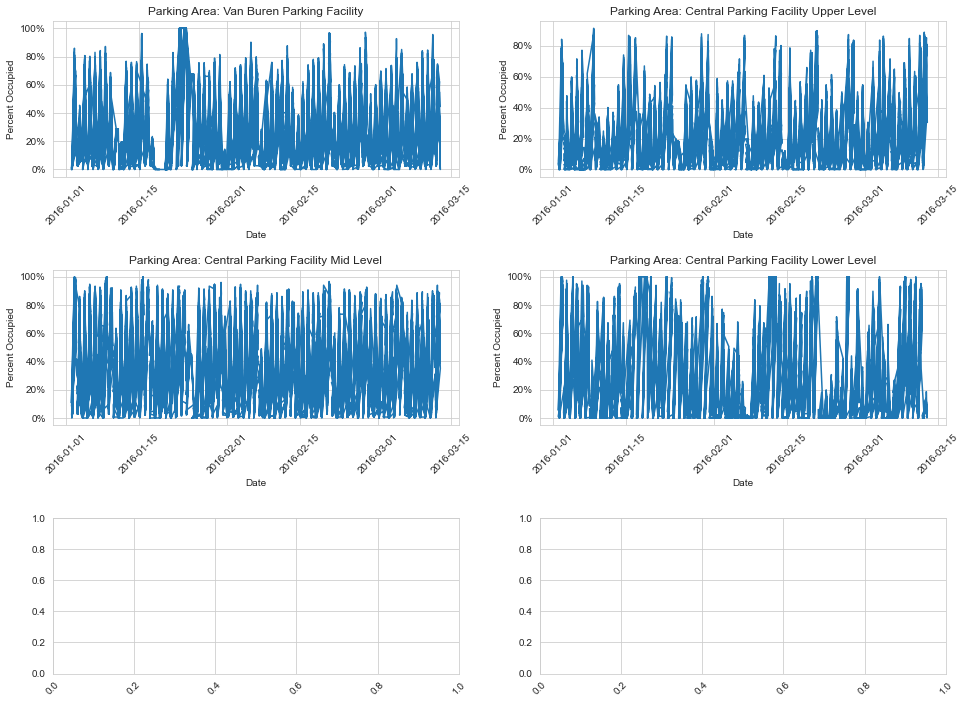

In [24]:
sample_plots_by_scn(df=df, num_graphs=5, num_per_row=2)

In [119]:
df_agg_dthh_updated = df.groupby('date_time_halfhour').agg({'Occupied':['sum','count'], 'TotalAvailable':['sum','count']})
df_agg_dthh_updated['PercentOccupied'] = df_agg_dthh_updated.Occupied['sum'] / df_agg_dthh_updated.TotalAvailable['sum']

In [121]:
df_agg_dthh_updated.drop(columns=['Occupied', 'TotalAvailable'], inplace=True)

In [122]:
df_agg_fillmissing = df_agg_dthh_updated.copy()
df_agg_fillmissing.sort_index(inplace=True)
df_agg_fillmissing.head()

,PercentOccupied
,
date_time_halfhour,
2016-01-02 00:00:00,0.031394
2016-01-02 00:30:00,0.016845
2016-01-02 01:00:00,0.006891
2016-01-02 01:30:00,0.004594
2016-01-02 02:00:00,0.000000


In [123]:
temp = pd.Series(df_agg_fillmissing.index.date).value_counts()
temp[temp<48]

Series([], dtype: int64)

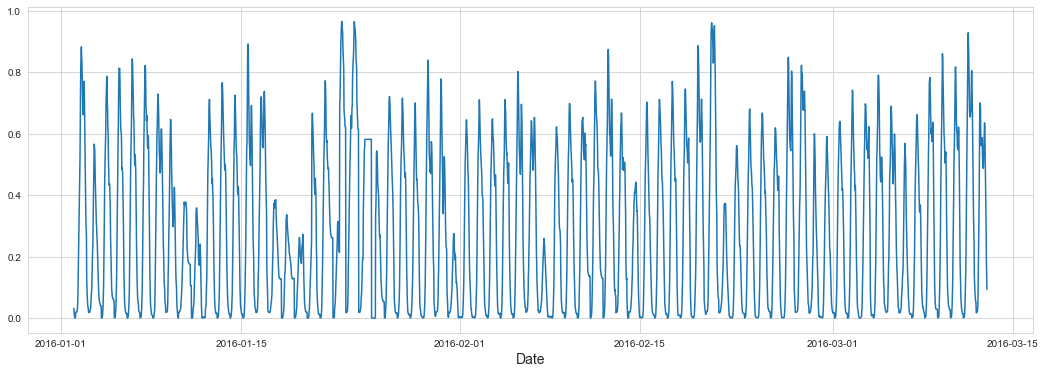

In [167]:
plt.figure(figsize=(18,6))
plt.plot(df_agg_fillmissing)
plt.plot(df_agg_fillmissing.shift(48))
plt.xlabel('Date', fontsize=14);

C:\Users\admanthr\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


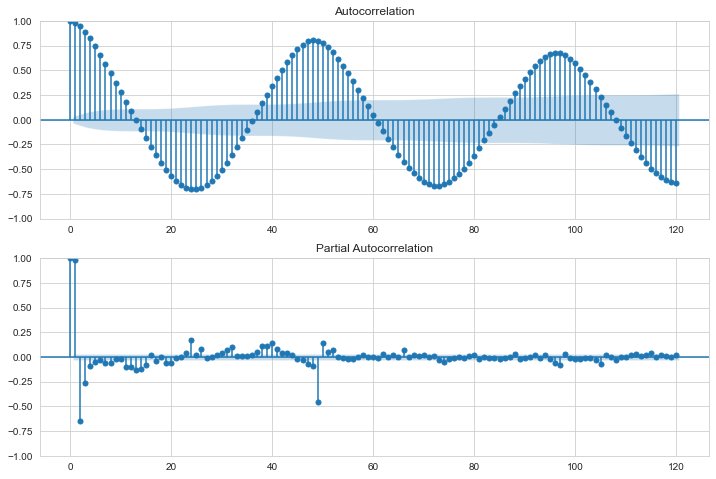

In [126]:
def subplots_acf_pacf(series):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(series, lags=120, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(series, lags=120, ax=ax2)
    plt.show()
subplots_acf_pacf(df_agg_fillmissing)

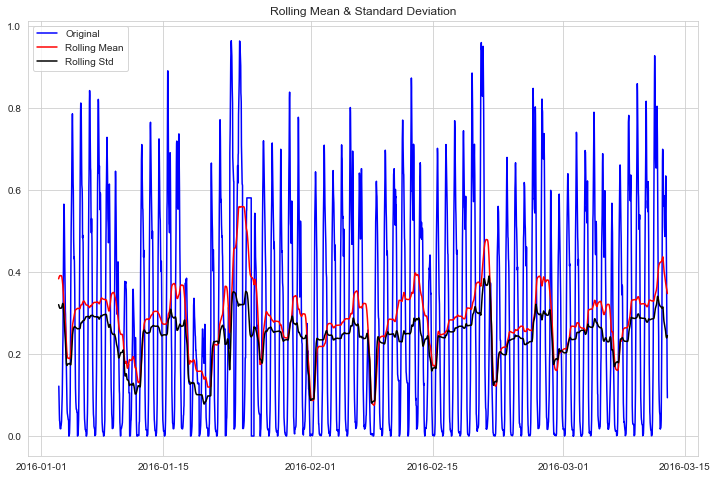

Results of Dickey-Fuller Test:
Test Statistic                -9.825355e+00
p-value                        5.205389e-17
#Lags Used                     2.900000e+01
Number of Observations Used    3.378000e+03
Critical Value (1%)           -3.432287e+00
Critical Value (5%)           -2.862396e+00
Critical Value (10%)          -2.567226e+00
dtype: float64


In [127]:
def test_stationarity(timeseries, window):

   #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

   #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
test_stationarity(df_agg_fillmissing.squeeze(), 48)

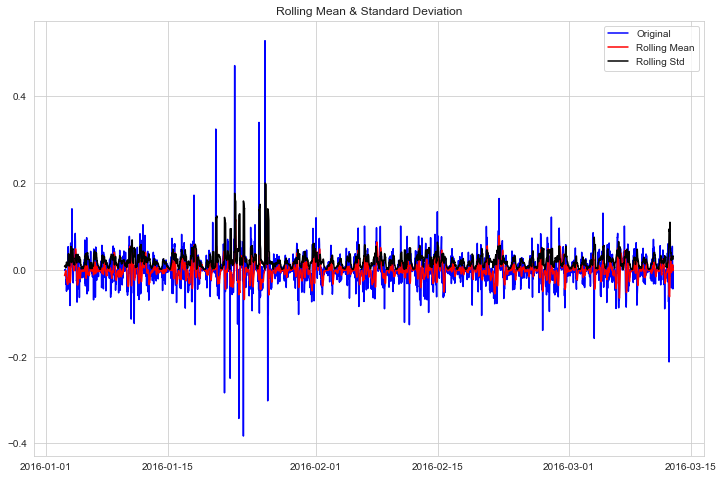

Results of Dickey-Fuller Test:
Test Statistic                -1.501008e+01
p-value                        1.058653e-27
#Lags Used                     2.900000e+01
Number of Observations Used    3.329000e+03
Critical Value (1%)           -3.432316e+00
Critical Value (5%)           -2.862409e+00
Critical Value (10%)          -2.567232e+00
dtype: float64


In [128]:
test_stationarity(df_agg_dthh_updated.diff(48).diff().dropna().squeeze(), 7)

In [155]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
print(tscv)


data_use = df_agg_fillmissing.reset_index()['PercentOccupied']

for train_index, test_index in tscv.split(data_use):
  train = data_use[train_index]
  test = data_use[test_index]

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [156]:
TimeSeriesSplit(max_train_size=None, n_splits=5)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [163]:
train.index = df_agg_fillmissing.index[:len(train)]
train.tail()

date_time_halfhour
2016-03-01 01:30:00    0.016845
2016-03-01 02:00:00    0.016080
2016-03-01 02:30:00    0.015314
2016-03-01 03:00:00    0.016080
2016-03-01 03:30:00    0.000000
Name: PercentOccupied, dtype: float64

In [165]:
test.index = df_agg_fillmissing.index[len(train):]
test.head()

date_time_halfhour
2016-03-01 04:00:00    0.000766
2016-03-01 04:30:00    0.001531
2016-03-01 05:00:00    0.004594
2016-03-01 05:30:00    0.006891
2016-03-01 06:00:00    0.026034
Name: PercentOccupied, dtype: float64

In [159]:
%%time
# Define and fit ARIMA model
arima_model = ARIMA(train, order=(48, 1, 0))
results_AR = arima_model.fit()

C:\Users\admanthr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\admanthr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\admanthr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\admanthr\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CPU times: total: 8min 11s
Wall time: 2min 3s


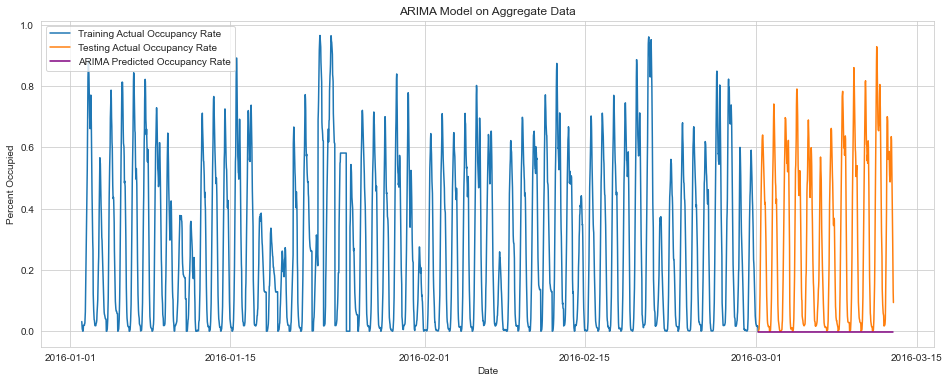

-----------------------------------------------------------------------------
ARIMA Model Metrics on Test Data
Explained Variance:
	 2.220446049250313e-16
MAE:
	 0.3117951588473555


In [166]:
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    # print("RMSE:\n\t", np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    # print("MAPE:\n\t", MAPE(y_true, y_pred))
    # print("r^2:\n\t", metrics.r2_score(y_true, y_pred))

plt.figure(figsize=(16,6))
plt.title('ARIMA Model on Aggregate Data')
plt.plot(train, label='Training Actual Occupancy Rate')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
y_pred_AR = pd.Series(results_AR.forecast(steps=len(test))[0], index=test.index)
plt.plot(test, label='Testing Actual Occupancy Rate')
plt.plot(y_pred_AR, color='purple', label='ARIMA Predicted Occupancy Rate')
plt.legend()

plt.show()


print('-'*77)
print('ARIMA Model Metrics on Test Data')
print('='*77)
report_metrics(test.squeeze(), y_pred_AR.squeeze())

In [169]:
%%time
# Define and fit SARIMA model
my_seasonal_order = (1, 1, 1, 48)
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=my_seasonal_order)
results_SAR = sarima_model.fit(disp=-1)

C:\Users\admanthr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\admanthr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)


CPU times: total: 8min 24s
Wall time: 2min 24s


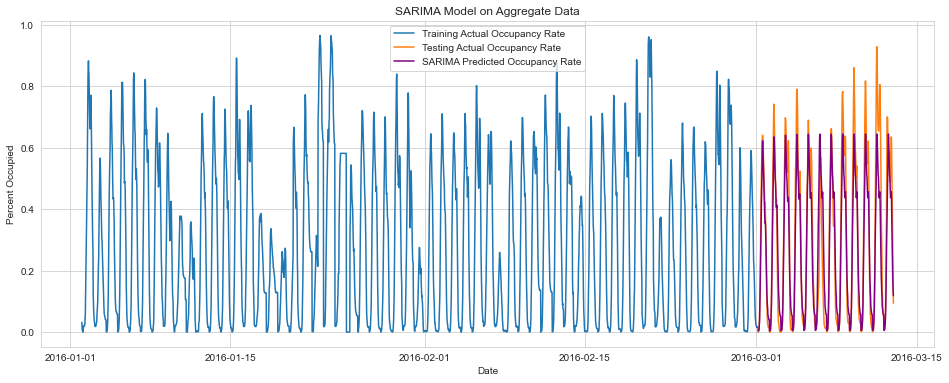

-----------------------------------------------------------------------------
SARIMA Model Metrics on Test Data
Explained Variance:
	 0.8594781074777673
MAE:
	 0.07519875936860163


In [171]:
plt.figure(figsize=(16,6))
plt.title('SARIMA Model on Aggregate Data')
plt.plot(train, label='Training Actual Occupancy Rate')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
y_pred_sar = pd.Series(results_SAR.forecast(steps=len(test)).values, index=test.index)
plt.plot(test, label='Testing Actual Occupancy Rate')
plt.plot(y_pred_sar, color='purple', label='SARIMA Predicted Occupancy Rate')
plt.legend()

plt.show()


print('-'*77)
print('SARIMA Model Metrics on Test Data')
print('='*77)
report_metrics(test.squeeze(), y_pred_sar.squeeze())

In [172]:
test.head()


date_time_halfhour
2016-03-01 04:00:00    0.000766
2016-03-01 04:30:00    0.001531
2016-03-01 05:00:00    0.004594
2016-03-01 05:30:00    0.006891
2016-03-01 06:00:00    0.026034
Name: PercentOccupied, dtype: float64

In [173]:
y_pred_AR.head()

date_time_halfhour
2016-03-01 04:00:00   -0.002557
2016-03-01 04:30:00   -0.002557
2016-03-01 05:00:00   -0.002557
2016-03-01 05:30:00   -0.002557
2016-03-01 06:00:00   -0.002557
dtype: float64

In [174]:
y_pred_sar.head()

date_time_halfhour
2016-03-01 04:00:00    0.003992
2016-03-01 04:30:00    0.004121
2016-03-01 05:00:00    0.005775
2016-03-01 05:30:00    0.008431
2016-03-01 06:00:00    0.021909
dtype: float64